In [76]:
import json
from collections import defaultdict
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import numpy
import random
import gzip
import dateutil.parser
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [77]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))
f.close()

In [78]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## How does the age of users influence their ratings of clothing items rented from Rent the Runway?

In [80]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'rating' in d and str(d['age']).isdigit() and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [81]:
ages = [int(d['age']) for d in clean_dataset]
ratings = [int(d['rating']) for d in clean_dataset]

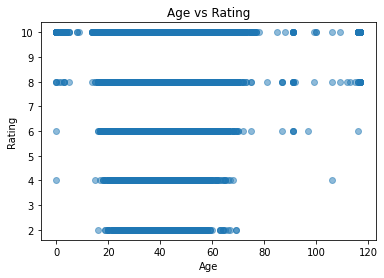

In [82]:
plt.scatter(ages, ratings, alpha=0.5)
plt.title('Age vs Rating')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.show()

In [83]:
# Prepare the data for linear regression
X = numpy.array([[1, age] for age in ages])  # Including the constant term
y = numpy.array(ratings).reshape(-1, 1)

In [84]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [85]:
theta = model.coef_
theta

array([[ 9.30426074e+00, -6.26219615e-03]])

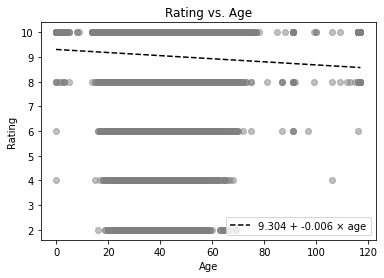

In [86]:
xplot = numpy.arange(min(ages), max(ages)+1)
yplot = [theta[0,0] + theta[0,1]*x for x in xplot]
plt.scatter(ages, ratings, color='grey', alpha=0.5)
plt.plot(xplot, yplot, color='k', linestyle='--', label=f"{theta[0,0]:.3f} + {theta[0,1]:.3f} × age")
plt.xlabel("Age")
plt.ylabel("Rating")
plt.title("Rating vs. Age")
plt.legend(loc='lower right')
plt.show()

In [87]:
df = pd.DataFrame(dataset)

## How do customer preferences and satisfaction, as indicated by the fit of rented items for different purposes, correlate with the overall trend in service usage over time?

In [88]:
# Convert 'review_date' to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

In [89]:
# Set the review_date as the index
df.set_index('review_date', inplace=True)

In [90]:
# Sort the data by date to prepare for the time series analysis
df.sort_index(inplace=True)

In [91]:
# Aggregating data by month to see the trend more clearly
monthly_data = df.resample('M').size()

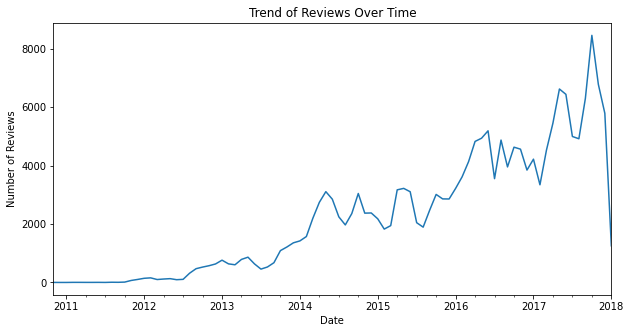

In [92]:
# Plotting the trend of reviews over time
plt.figure(figsize=(10, 5))
monthly_data.plot(title='Trend of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

In [93]:
# Replace 'nan' string with actual NaN and drop those rows
df['rented for'] = df['rented for'].replace('NaN', pd.NA)
df.dropna(subset=['rented for'], inplace=True)

In [94]:
# We will create a cross-tabulation of the 'fit' variable with the 'rented for' category
fit_rented_for_crosstab = pd.crosstab(df['fit'], df['rented for'])
fit_rented_for_crosstab

rented for,date,everyday,formal affair,other,party,party: cocktail,vacation,wedding,work
fit,,,,,,,,,
fit,5261,11608,31089,11334,25874,1,2914,43111,10857
large,935,3563,4451,2038,4546,0,669,6200,2304
small,1192,1651,4868,2016,5206,0,492,8473,1881


/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_29012/907045477.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


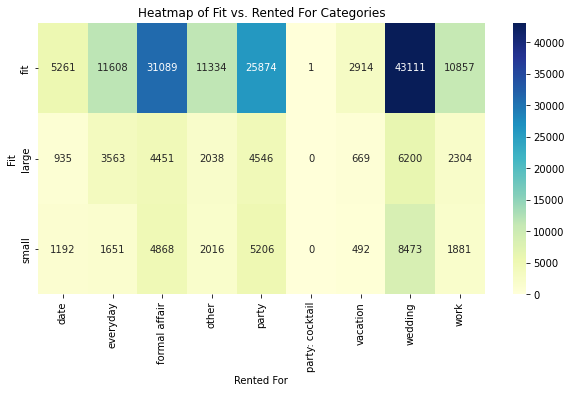

In [95]:
# Visualizing the cross-tabulation with a heatmap
plt.figure(figsize=(10, 5))

ax = sns.heatmap(fit_rented_for_crosstab, annot=True, fmt="d", cmap="YlGnBu")

# Set title and labels
ax.set_title('Heatmap of Fit vs. Rented For Categories')
ax.set_xlabel('Rented For')
ax.set_ylabel('Fit')

# Display the plot
ax.figure.show()

## How does age and review length correlate and how does it affect the overall rating of rented items?

In [5]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'review_text' in d and str(d['age']).isdigit():
        clean_dataset.append(d)

In [6]:
ages = [int(d['age']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

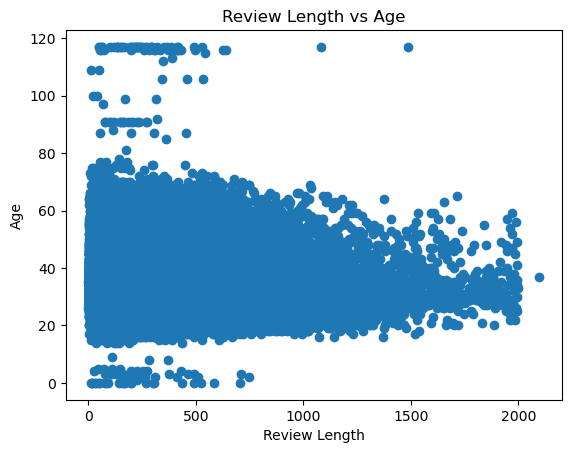

In [7]:
plt.scatter(reviewLen, ages)
plt.xlabel('Review Length')
plt.ylabel('Age')
plt.title('Review Length vs Age')

plt.show()

In [8]:
clean_dataset = []
for d in dataset:
    if 'rating' in d and 'review_text' in d and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [9]:
ratings = [int(d['rating']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

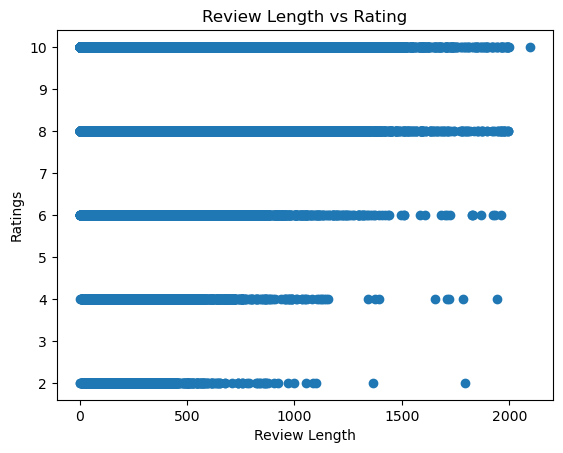

In [10]:
plt.scatter(reviewLen, ratings)
plt.xlabel('Review Length')
plt.ylabel('Ratings')
plt.title('Review Length vs Rating')

plt.show()

## What are the distribution of rating scores?

In [96]:
score_freq = df.groupby('rating').count().reset_index()
score_freq['rating'] = score_freq['rating'].astype(int)

score_freq = score_freq.sort_values(by='rating')

score_freq

,rating,fit,user_id,bust size,item_id,weight,rented for,review_text,body type,review_summary,category,height,size,age
1,2,1045,1045,945,1045,856,1045,1045,988,1045,1045,1037,1045,1041
2,4,2791,2791,2546,2791,2401,2791,2791,2622,2791,2791,2777,2791,2777
3,6,10697,10697,9773,10697,9111,10697,10697,10059,10697,10697,10657,10697,10650
4,8,53388,53388,48383,53388,45042,53388,53388,49663,53388,53388,53203,53388,53125
0,10,124531,124531,112411,124531,105085,124531,124531,114483,124531,124531,124101,124531,123900


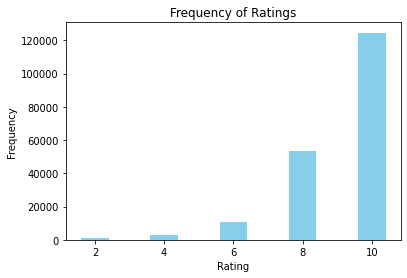

In [97]:
plt.bar(score_freq['rating'], score_freq['user_id'], color='skyblue')

# Add labels and title
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()